<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) | [Contents](Index.ipynb) | [Further Machine Learning Resources](05.15-Learning-More.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.14-Image-Features.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# 應用: 臉部辨識

真實世界的資料集會有許多雜訊和異質性資料，也可能會有缺失的特徵，以及在資料中包含難以對應到乾淨的``[n_samples, n_features]``矩陣。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## HOG特徵

Histogram of Gradients是一個非常直接的特徵萃取程序，此程式被開發在識別影像中行人的領域上。HOG包含了以下的步驟:

1. 可選用的前置正規化影像。這讓特徵可以對抗在明度中的變化
2. 使用2個濾波器卷積此影像，這2個濾波器分別對水平和垂直亮度梯度敏感。它們可以把邊緣、輪廓、以及文字資料擷取出來
3. 分割此影像成為預先訂義尺寸的格子，然後計算每一個格子中梯度方向的直方圖
4. 在每一個格子中藉由和鄰接格子區塊的比較正規化直方圖。進一步壓抑在影像中明度的影響
5. 從每一個格子中的資訊建構一個一維的特徵向量

在Scikit-Image專案中內建了一個快速的HOG萃取器，可以快速試用，並視覺化出每一個格子中的方向梯度:

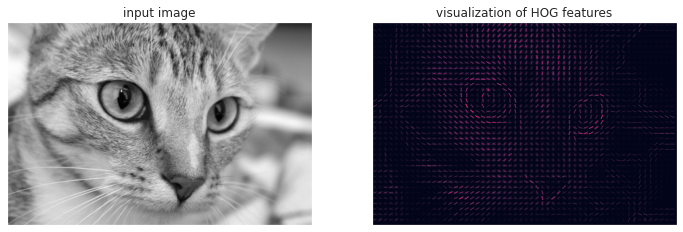

In [3]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

## 使用HOG: 一個簡單的臉部偵測器

使用這些HOG特徵，可以在任一個Scikit-Learn評估器中建立一個簡單的臉部偵測演算法;在此將會使用一個線性支持向量機。以下是需要的步驟:
1. 取得一組臉部的影像縮圖以組成"正向的"訓練樣本
2. 取得一組沒有臉部的影像縮圖以組成"負向的"訓練樣本
3. 從這些訓練樣本中萃取HOG特徵
4. 在這些樣本中訓練一個線性SVM分類器
5. 對於"未知"的影像，傳遞一個滑動窗跨越此影像，使用此模型去評估此視窗中是否包含臉的特徵
6. 如果偵測重疊，結合它們成為一個單一視窗

接下來開始逐步展示嘗試:

### 1. 取得一組正向的訓練樣本集合

從找出一些正向的訓練樣本開始，這些訓練樣本展現了臉的多樣性。有一個可以運用的簡單資料集，在Wild資料集中的labeled faces，可以從Scikit-Learn中下載:

In [4]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

這些資料提供了13,000個臉部影像樣本可以做為訓練用

### 2. 取得一組負向的訓練樣本集合

需要一組類似大小的縮圖，而這些圖不能有任何一張臉在其中。其中一個可以做的方式是去取得任一個輸入影像的素材，從它們之中以各種比例來擷取出縮圖。在此，可以使用一些在
Scikit-Image中存在的影像，它們放在Scikit-Learn的``PatchExtractor``之中:

In [5]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys


In [6]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

現在有30,000個適合的影像，它們都沒有任何一張臉在其中，以下為初步視覺化的結果

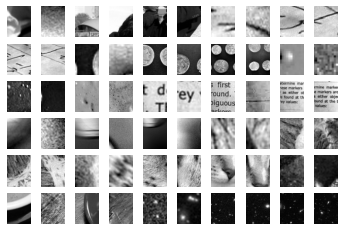

In [7]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

目的是希望可以涵蓋沒有臉的空間，讓演算法可以理解

### 3. 結合這2個集合，萃取出HOG特徵

有正向和負向樣本，可以把它們結合起來並計算HOG特徵。(此步驟會要一段時間，因HOG特徵包含了對於每一個影像的繁瑣運算)

In [8]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [9]:
X_train.shape

(43233, 1215)

在1215個維度中留下了43,000個訓練樣本，現在有了可以餵給Scikit-Learn的資料格式

### 4. 在SVM中訓練

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.94795883, 0.97143518, 0.97224471, 0.97501735, 0.97374508])

In [13]:
# Grid search
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

0.9885272620319941

In [14]:
grid.best_params_

{'C': 1.0}

In [15]:
# 取得最佳的模型
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

### 5. 在新的影像中找出人臉

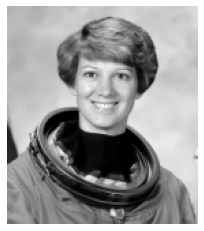

In [22]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off'); # 關閉軸

In [17]:
# 建立一個在此影像上的每一個小圖片中的迭代運行視窗，並對每一個小圖片計算HOG特徵
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [18]:
# 最後取出這些HOG特徵小圖片，並使用模型去評估小圖片中是否有人臉
labels = model.predict(patches_hog)
labels.sum()

48.0

在2,000張小圖片中，找到48個。使用這些小圖片的資訊以顯示出它們在測試影像中放的位置，把它們使用矩陣繪出:

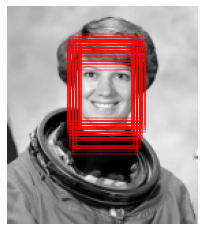

In [19]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

所有偵測到的小圖片把它重疊在一起，就是找到的這張影像上的人臉。

## 警告和改良

### 訓練資料集，尤其是負向的特徵，不是很完整

有許多很像人臉的紋理並不在此訓練集中，以致於目前訓練出來的模型容易誤認資料。

### 我們應該要結合重疊的偵測小圖片

可試著把一些重疊的偵測群組減少成為一個單一的偵測，避免特徵過度集中在同一個人身上。這可能可藉由非監督式集群方法 (MeanShift Clustering)或藉由一個程序式的嘗試像是*non-maximum suppression*。

### 深度學習應該被考慮到

HOG在影像特徵萃取不再是最佳技術，深度學習如CNN可被執行且有機會達到更好的效果。